In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
from matplotlib.lines import Line2D 
import numpy as np
import operator
import collections
import heapq
import math

In [2]:
class Node:
    def __init__(self, x, y, g):
        self.x = x
        self.y = y
        self.g = g
        self.h = 0
        self.f = self.g + self.h
        self.parent = None
        self.childNodes = []
        
    def __lt__(self, other):
        return self.h < other.h

In [3]:
class UserMap:
    def __init__(self):
        self.xmin = 0.0
        self.ymin = 0.0
        self.xmax = 0.0
        self.ymax = 0.0
        self.cellsize = 0.0
        self.threshold = 0
        self.polygons = []
        self.blockedPolygons = []
        self.nodes = dict()
        self.startNode = None
        self.goalNode = None

In [4]:
def is_inside_area(x, y, userMap):
    if(userMap.xmin <= x and userMap.ymin <= y and x <= userMap.xmax and y <= userMap.ymax) :
        return True
    else:
        return False


def is_inside_polygon(x, y, xmin,ymin, xmax, ymax):
    if(xmin <= x and ymin <= y and x <= xmax and y <= ymax) :
        return True
    else:
        return False


def get_edge_cost(x1, y1, x2, y2, blockedPolygons, isDiagonal, edge) :
    fromPoint = Point(x1, y1)
    toPoint = Point(x2, y2)
    count = 0
    for i in range(len(blockedPolygons)):
        
        if (edge == "T" and ((blockedPolygons[i].bounds[0] == x1 and blockedPolygons[i].bounds[1] == y1 and
            blockedPolygons[i].bounds[0] == x2 and blockedPolygons[i].bounds[3] == y2) or
            (blockedPolygons[i].bounds[2] == x1 and blockedPolygons[i].bounds[1] == y1 and
            blockedPolygons[i].bounds[2] == x2 and blockedPolygons[i].bounds[3] == y2))):
            count += 1
        
        if (edge == "R" and ((blockedPolygons[i].bounds[0] == x1 and blockedPolygons[i].bounds[1] == y1 and
            blockedPolygons[i].bounds[2] == x2 and blockedPolygons[i].bounds[1] == y2) or
            (blockedPolygons[i].bounds[0] == x1 and blockedPolygons[i].bounds[3] == y1 and
            blockedPolygons[i].bounds[2] == x2 and blockedPolygons[i].bounds[3] == y2))):
            count += 1
        
        if (edge == "B" and ((blockedPolygons[i].bounds[0] == x1 and blockedPolygons[i].bounds[3] == y1 and
            blockedPolygons[i].bounds[0] == x2 and blockedPolygons[i].bounds[1] == y2) or
            (blockedPolygons[i].bounds[2] == x1 and blockedPolygons[i].bounds[3] == y1 and
            blockedPolygons[i].bounds[2] == x2 and blockedPolygons[i].bounds[1] == y2))):
            count += 1
        
        if (edge == "L" and ((blockedPolygons[i].bounds[2] == x1 and blockedPolygons[i].bounds[1] == y1 and
            blockedPolygons[i].bounds[0] == x2 and blockedPolygons[i].bounds[1] == y2) or
            (blockedPolygons[i].bounds[2] == x1 and blockedPolygons[i].bounds[3] == y1 and
            blockedPolygons[i].bounds[0] == x2 and blockedPolygons[i].bounds[3] == y2))):
            count += 1
        
        if (edge == "TRD" and (blockedPolygons[i].bounds[0] == x1 and blockedPolygons[i].bounds[1] == y1 and
            blockedPolygons[i].bounds[2] == x2 and blockedPolygons[i].bounds[3] == y2)):
            count += 1
        
        if (edge == "BRD" and (blockedPolygons[i].bounds[0] == x1 and blockedPolygons[i].bounds[3] == y1 and
            blockedPolygons[i].bounds[2] == x2 and blockedPolygons[i].bounds[1] == y2)):
            count += 1
        
        if (edge == "BLD" and (blockedPolygons[i].bounds[2] == x1 and blockedPolygons[i].bounds[3] == y1 and
            blockedPolygons[i].bounds[0] == x2 and blockedPolygons[i].bounds[1] == y2)):
            count += 1
        
        if (edge == "TLD" and (blockedPolygons[i].bounds[2] == x1 and blockedPolygons[i].bounds[1] == y1 and
            blockedPolygons[i].bounds[0] == x2 and blockedPolygons[i].bounds[3] == y2)):
            count += 1
        
        if count == 2 and not(isDiagonal):
            return 0
        
        if(count == 1 and isDiagonal):
            return 0           
    
    if(count == 0 and not(isDiagonal)):
        return 1.0
    if(count == 0 and isDiagonal):
        return 1.5
    if(count == 1 and not(isDiagonal)):
        return 1.3

In [15]:
def is_goal(node, goalNode):
    if node.x == goalNode.x and node.y == goalNode.y :
        return True
    else :
        return False


def get_index(nodeList, node):
    for i in range(len(nodeList)):
        if nodeList[i][1].x == node.x and nodeList[i][1].y == node.y :
            return i
    return -1


def is_present(nodeList, node):
    for i in range(len(nodeList)):
        if nodeList[i].x == node.x and nodeList[i].y == node.y :
            return True
    return False


def heuristic1(node, goalNode):
    x_dist = abs(node.x - goalNode.x)
    y_dist = abs(node.y - goalNode.y)
    h_diagonal = min(x_dist, y_dist)
    h_straight = x_dist + y_dist
    return node.g * (h_straight - 2*h_diagonal) + 1.5 * h_diagonal


def heuristic(node, goalNode):
    x_dist = abs(node.x - goalNode.x)
    y_dist = abs(node.y - goalNode.y)
    diagonal_dist = math.sqrt(x_dist**2 + y_dist**2)
    scale = math.sqrt(2*(0.002**2)) 
    return np.ceil(diagonal_dist/scale)


def a_start_algorithm(userMap):
    openList = []
    closeList = []
    isPathFound = False
    heapq.heappush(openList, (0, userMap.startNode))
    
    while len(openList) > 0 :
        currentNode = heapq.heappop(openList)[1]
#         print("==========================")
#         print("Selected f: ",currentNode.f)
#         print("==========================")
        if is_goal(currentNode, userMap.goalNode):
            isPathFound = True
            closeList.append(currentNode)
            break
        
        for node in currentNode.childNodes:
            
            if is_present(closeList, node) :
                continue
            
            if ((currentNode.x == userMap.xmin and node.x == userMap.xmin) or
                (currentNode.x == userMap.xmax and node.x == userMap.xmax) or
                (currentNode.y == userMap.ymin and node.y == userMap.ymin) or
                (currentNode.y == userMap.ymax and node.y == userMap.ymax)) :
                    continue
            
            nextNode = userMap.nodes[str(node.x) + "," + str(node.y)]
            nextNode.g = node.g + currentNode.g
            nextNode.h = heuristic(nextNode, userMap.goalNode)
#             print("G, H :", nextNode.g, nextNode.h)
            nextNode.f = nextNode.g + nextNode.h
#             print("Added f: ",nextNode.f)
            nextNode.parent = currentNode
            
            index = get_index(openList, node)
            if index >= 0 and openList[index][1].f > nextNode.f :
                openList[index] = (nextNode.f, nextNode)
            
            if index == -1 :
                heapq.heappush(openList, (nextNode.f, nextNode))
            
        closeList.append(currentNode)
    return isPathFound, closeList


Mean: 16.15123194562447
Standard Dev: 18.531162408189786
Start Point: -73.55183070150008,45.4900685085
End Point: -73.58983070149999,45.52806850850005
Creating Map grid...
Map grid creation completed
Path Search started
Path found:  True
Total Cost: 51.0


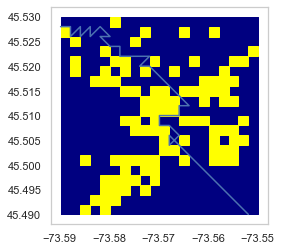

In [18]:

points = gpd.read_file('C:\\Users\\vetal\\Documents\\Books\\AI-6721\\Shape\\crime_dt.shp')

userMap = UserMap()
# userMap.xmin, userMap.ymin, userMap.xmax, userMap.ymax = -73.59, 45.49, -73.55, 45.53
userMap.xmin, userMap.ymin, userMap.xmax, userMap.ymax = points.total_bounds
userMap.cellsize = 0.002
userMap.threshold = 75
startPoint = Point(userMap.xmax, userMap.ymin)
endPoint = Point(userMap.xmin, userMap.ymax)

columns = int(np.ceil(abs(userMap.xmax - userMap.xmin) / userMap.cellsize))
rows = int(np.ceil(abs(userMap.ymax - userMap.ymin) / userMap.cellsize))

# print(rows)
# print(columns)

x1 = userMap.xmin
x2 = userMap.xmin + userMap.cellsize

for x in range(columns):
    y1 = userMap.ymin
    y2 = userMap.ymin + userMap.cellsize
    for y in range(rows):
        userMap.polygons.append( Polygon([(x1,y1), (x2, y1), (x2, y2), (x1, y2)]) )
        y1 = y2
        y2 += userMap.cellsize
    x1 = x2
    x2 += userMap.cellsize

grid = gpd.GeoDataFrame({'geometry':userMap.polygons})
sns.set(style='whitegrid');
fig,ax = plt.subplots()
# plt.figure(figsize=(30,30))
ax.grid(False)
ax = grid.plot(ax=ax,alpha=1,color='navy',edgecolor='navy')


dataframe = points.geometry
df = pd.DataFrame()
df['long'] = dataframe.geometry.x
df['lat'] = dataframe.geometry.y
group_value = df.groupby(['lat','long']).size().reset_index(name='counts')
mean = group_value['counts'].mean(axis=0)
stddev = group_value['counts'].std(axis=0)
print("Mean:",mean)
print("Standard Dev:",stddev)
group_value.sort_values(['long','lat'],axis=0, ascending=True, inplace=True)
# print(group_value)

blockCrimeRate_dict = dict()
startNodeKey = ""
endNodeKey = ""

for i in range(len(userMap.polygons)):
    blockCrimeRate_dict[userMap.polygons[i].bounds] = [i, 0];
    xmin, ymin, xmax, ymax = userMap.polygons[i].bounds
    if len(startNodeKey)==0 and is_inside_polygon(startPoint.x, startPoint.y, xmin, ymin, xmax, ymax):
        startNodeKey = str(xmin) + "," + str(ymin)
    if len(endNodeKey)==0 and is_inside_polygon(endPoint.x, endPoint.y, xmin, ymin, xmax, ymax):
        endNodeKey = str(xmin) + "," + str(ymin)

print("Start Point:", startNodeKey)
print("End Point:", endNodeKey)
print("Creating Map grid...")

for index, point in group_value.iterrows():
    for i in range(len(userMap.polygons)):
        xmin, ymin, xmax, ymax = userMap.polygons[i].bounds
        if is_inside_polygon(point.long, point.lat, xmin, ymin, xmax, ymax):
            blockCrimeRate_dict[userMap.polygons[i].bounds][1] += point.counts
            break


blockCrimeRate_dict = collections.OrderedDict(sorted(blockCrimeRate_dict.items(), key=lambda kv:kv[1][1], reverse=True))

thresholdIndex = int(np.ceil(len(blockCrimeRate_dict) * (100 - userMap.threshold) / 100))
# print(thresholdIndex)

# crimeThreshold = list(blockCrimeRate_dict.values())[thresholdIndex][1]
# print(crimeThreshold)
# for value in blockCrimeRate_dict.values():
#     if value[1] > crimeThreshold:
#         polygon = polygons[value[0]]
#         patch = PolygonPatch(polygon, facecolor='yellow', edgecolor='yellow', alpha=1)
#         ax.add_patch(patch)
#         userMap.blockedPolygons.append(polygon)
#     else:
#         break;

crimeData = list(blockCrimeRate_dict.values())
# print(len(crimeData))
for i in range(len(crimeData)):
    if i < thresholdIndex:
        polygon = userMap.polygons[crimeData[i][0]]
        patch = PolygonPatch(polygon, facecolor='yellow', edgecolor='yellow', alpha=1)
        ax.add_patch(patch)
        userMap.blockedPolygons.append(polygon)
    else:
        break;

for i in range(len(userMap.polygons)):
    x1, y1 = userMap.polygons[i].bounds[0], userMap.polygons[i].bounds[1]
    node = Node(x1, y1, 0)
    childNodes = []
    cellsize = userMap.cellsize

    if(is_inside_area(x1, y1+cellsize, userMap)) :
        edgeCost = get_edge_cost(x1, y1, x1, y1+cellsize, userMap.blockedPolygons, False, "T")
        if(edgeCost > 0):
            childNodes.append(Node(x1, y1+cellsize, edgeCost))

    if(is_inside_area(x1+cellsize, y1, userMap)) :
        edgeCost = get_edge_cost(x1, y1, x1+cellsize, y1, userMap.blockedPolygons, False, "R")
        if(edgeCost > 0):
            childNodes.append(Node(x1+cellsize, y1, edgeCost))

    if(is_inside_area(x1, y1-cellsize, userMap)) :
        edgeCost = get_edge_cost(x1, y1, x1, y1-cellsize, userMap.blockedPolygons, False, "B")
        if(edgeCost > 0):
            childNodes.append(Node(x1, y1-cellsize, edgeCost))

    if(is_inside_area(x1-cellsize, y1, userMap)) :
        edgeCost = get_edge_cost(x1, y1, x1-cellsize, y1, userMap.blockedPolygons, False, "L")
        if(edgeCost > 0):
            childNodes.append(Node(x1-cellsize, y1, edgeCost))

    if(is_inside_area(x1+cellsize, y1+cellsize, userMap)) :
        edgeCost = get_edge_cost(x1, y1, x1+cellsize, y1+cellsize, userMap.blockedPolygons, True, "TRD")
        if(edgeCost > 0):
            childNodes.append(Node(x1+cellsize, y1+cellsize, edgeCost))

    if(is_inside_area(x1+cellsize, y1-cellsize, userMap)) :
        edgeCost = get_edge_cost(x1, y1, x1+cellsize, y1-cellsize, userMap.blockedPolygons, True, "BRD")
        if(edgeCost > 0):
            childNodes.append(Node(x1+cellsize, y1-cellsize, edgeCost))

    if(is_inside_area(x1-cellsize, y1-cellsize, userMap)) :
        edgeCost = get_edge_cost(x1, y1, x1-cellsize, y1-cellsize, userMap.blockedPolygons, True, "BLD")
        if(edgeCost > 0):
            childNodes.append(Node(x1-cellsize, y1-cellsize, edgeCost))

    if(is_inside_area(x1-cellsize, y1+cellsize, userMap)) :
        edgeCost = get_edge_cost(x1, y1, x1-cellsize, y1+cellsize, userMap.blockedPolygons, True, "TLD")
        if(edgeCost > 0):
            childNodes.append(Node(x1-cellsize, y1+cellsize, edgeCost))

    node.childNodes = childNodes
    userMap.nodes[str(x1) + "," + str(y1)] = node


userMap.startNode = userMap.nodes[startNodeKey]
userMap.goalNode = userMap.nodes[endNodeKey]
# print(len(userMap.nodes))
print("Map grid creation completed")


print("Path Search started")
isPathFound, pathNodes = a_start_algorithm(userMap)
print("Path found: ", isPathFound)

pathNodes.reverse()
currentNode = pathNodes[0]
print("Total Cost:", currentNode.g)

x_path = []
y_path = []
while not(is_goal(currentNode, userMap.startNode)) : 
    x_path.append(currentNode.x)
    y_path.append(currentNode.y)
    currentNode = currentNode.parent

x_path.append(userMap.startNode.x)
y_path.append(userMap.startNode.y)

path = Line2D(x_path, y_path)
ax.add_line(path)
# plt.grid(b=None)
plt.show()
